# Importing & Loading Required Packages

In [56]:
import json # will be needed for saving preprocessing details
import numpy as np # for data manipulation
import pandas as pd # for data manipulation
from sklearn.model_selection import train_test_split # will be used for data split
from sklearn.preprocessing import LabelEncoder # for preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier # for training the algorithm
from sklearn.ensemble import ExtraTreesClassifier # for training the algorithm
import joblib # for saving algorithm and preprocessing objects
import pickle
from pandas.api.types import CategoricalDtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Loading data
In this tutorial, I will use Adult Income data set. In this data set, the ML will be used to predict whether income exceeds $50K/year based on census data. 
Code to load data and show first rows of data:

In [8]:
# load dataset
df = pd.read_csv('https://raw.githubusercontent.com/pplonski/datasets-for-start/master/adult/data.csv', skipinitialspace=True)
#x_cols = [c for c in df.columns if c != 'income']
# set input matrix and target column
X = df.loc[:, df.columns != 'income']
y = df['income']
# show first rows of data
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


The X matrix has 32,561 rows and 14 columns. This is input data for our algorithm, each row describes one person. The y vector has 32,561 values indicating whether income exceeds 50K per year.

Before starting data preprocessing we will split our data into training, and testing subsets. We will use 30% of the data for testing.

In [5]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Before starting data preprocessing we will split our data into training, and testing subsets. We will use 30% of the data for testing.

In [33]:
# data split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)

# Data pre-processing
In our data set, there are missing values and categorical columns. For ML algorithm training we will use the Random Forest algorithm from the sklearn package. In the current implementation it can not handle missing values and categorical columns, that's why we need to apply pre-processing algorithms.

To fill missing values we will use the most frequent value in each column (there are many other filling methods, the one I select is just for example purposes).

In [34]:
#Checking which features have null values.
X_train.isnull().sum()

age                  0
workclass         1456
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1461
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     463
dtype: int64

In [35]:
# fill missing values
train_mode = dict(X_train.mode().iloc[0]) # Gets the most frequent value in each column
X_train = X_train.fillna(train_mode)
X_test = X_test.fillna(train_mode)
print(train_mode)

{'age': 36.0, 'workclass': 'Private', 'fnlwgt': 123011, 'education': 'HS-grad', 'education-num': 9.0, 'marital-status': 'Married-civ-spouse', 'occupation': 'Prof-specialty', 'relationship': 'Husband', 'race': 'White', 'sex': 'Male', 'capital-gain': 0.0, 'capital-loss': 0.0, 'hours-per-week': 40.0, 'native-country': 'United-States'}


From train_mode you see, that for example in the age column the most frequent value is 31.0.

Let's convert categoricals into numbers. I will use LabelEncoder from sklearn package:

In [36]:
# convert categoricals
encoders = {}
for column in ['workclass', 'education', 'marital-status',
                'occupation', 'relationship', 'race',
                'sex','native-country']:
    categorical_convert = LabelEncoder()
    X_train[column] = categorical_convert.fit_transform(X_train[column])
    X_test[column] = categorical_convert.fit_transform(X_test[column])
    #X_test[column] = categorical_convert.fit_transform(X_test[column])
    encoders[column] = categorical_convert

# Algorithms Training
Data is ready, so we can train our Random Forest algorithm.

In [37]:
# train the Random Forest algorithm
rf = RandomForestClassifier(n_estimators = 100)
rf = rf.fit(X_train, y_train)

We will also train Extra Trees & Logistic regression algorithm:

In [38]:
# train the Extra Trees algorithm
et = ExtraTreesClassifier(n_estimators = 100)
et = et.fit(X_train, y_train)

# train the logistic regression
LR = LogisticRegression(random_state=0)
LR = LR.fit(X_train, y_train)

# Prediction

In [47]:
predicted_classes_RF = rf.predict(X_test)
print('Random Forest Model Accuracy = ' , accuracy_score(predicted_classes_RF, y_test)*100 , '%')

Random Forest Model Accuracy =  85.69015814524796 %


In [50]:
predicted_classes_et = et.predict(X_test)
print('Extra Trees Model Accuracy = ' , accuracy_score(predicted_classes_et, y_test)*100 , '%')

Extra Trees Model Accuracy =  84.12405957316138 %


In [51]:
predicted_classes_LR = LR.predict(X_test)
print('Logistic Regression Model Accuracy = ' , accuracy_score(predicted_classes_LR, y_test)*100,'%')

Logistic Regression Model Accuracy =  79.53324120988792 %


# Let’s plot the confusion matrix
Choosing RF as a base model as it has the best accuracy

Text(33.0, 0.5, 'Actual classes')

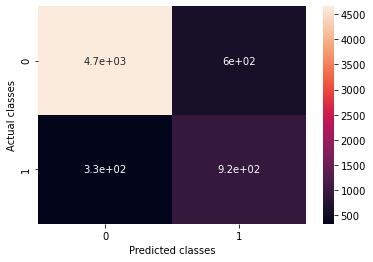

In [57]:
cfm = confusion_matrix(predicted_classes_RF, y_test.values)
sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

# Saving Pre-Processing Steps & Trained Models
As you see, training the algorithm is easy, just 2 lines of code - much less than data reading and pre-processing. Now, let's save the algorithm that we have created. The important thing to notice is that the ML algorithm is not only the rf and et variable (with model weights), but we also need to save pre-processing variables train_mode and encoders as well. For saving, I will use joblib package.

In [65]:
# save preprocessing objects and RF algorithm
joblib.dump(train_mode, "./Pre_Processing_Step_A_Filling_Missing_train_mode.joblib", compress=True)
joblib.dump(encoders, "./Pre_Processing_Step_B_Label_encoders.joblib", compress=True)
joblib.dump(rf, "./ML_Model_Random_Forest.joblib", compress=True)
joblib.dump(et, "./ML_Model_extra_trees.joblib", compress=True)

['./ML_Model_extra_trees.joblib']